**first write all the import statements required for our sentimental analysis on a dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer as ss
from wordcloud import WordCloud

In [ ]:
import nltk
nltk.download('punkt_tab', force=True)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
print(nltk.data.path)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving movie_reviews_200rows.csv to movie_reviews_200rows.csv


**next load the dataset and print the first five rows of the dataset**

In [ ]:
df = pd.read_csv("movie_reviews_200rows.csv")
df.head()

,id,movie_title,reviewer_name,review_date,rating,review,sentiment_to_num
0,1,The Lion King,baileydavid,2021-10-04,2.0,Not worth the hype.,0
1,2,The Godfather,samanthaturner,2024-07-10,3.0,Terrible acting.,0
2,3,The Lion King,drodriguez,2015-12-31,7.7,A must-watch.,1
3,4,Titanic,andrea31,2023-08-20,6.3,Absolutely loved it!,1
4,5,Inception,paula97,2015-10-19,1.8,Disappointing plot.,0


**next step is text preprocessing of the dataset**

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(.)\1+',r'\1',text)
    text = re.sub(r'<.*?>','',text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_review'] = df['review'].apply(preprocess_text)
df.head()

,id,movie_title,reviewer_name,review_date,rating,review,sentiment_to_num,cleaned_review
0,1,The Lion King,baileydavid,2021-10-04,2.0,Not worth the hype.,0,worth hype
1,2,The Godfather,samanthaturner,2024-07-10,3.0,Terrible acting.,0,terible acting
2,3,The Lion King,drodriguez,2015-12-31,7.7,A must-watch.,1,mustwatch
3,4,Titanic,andrea31,2023-08-20,6.3,Absolutely loved it!,1,absolutely loved
4,5,Inception,paula97,2015-10-19,1.8,Disappointing plot.,0,disapointing plot


In [ ]:
df.isnull().sum()
sia=ss()
df['polarity_scores']=df['review'].apply(lambda r:sia.polarity_scores(r))
df['compound']=df['polarity_scores'].apply(lambda x:x['compound'])
df['Vader_sentiment_labels']=df['compound'].apply(lambda x:'Positive' if x>0 else 'Negative')
df['vader_to_num']=df['Vader_sentiment_labels'].map({'Positive': 1, 'Negative': 0})
if 'sia.polarity_scores' in df.columns:
    df.drop('sia.polarity_scores', axis=1, inplace=True)
df.head(10)

,id,movie_title,reviewer_name,review_date,rating,review,sentiment_to_num,cleaned_review,polarity_scores,compound,Vader_sentiment_labels,vader_to_num
0,1,The Lion King,baileydavid,2021-10-04,2.0,Not worth the hype.,0,worth hype,"{'neg': 0.357, 'neu': 0.643, 'pos': 0.0, 'comp...",-0.1695,Negative,0
1,2,The Godfather,samanthaturner,2024-07-10,3.0,Terrible acting.,0,terible acting,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...",-0.4767,Negative,0
2,3,The Lion King,drodriguez,2015-12-31,7.7,A must-watch.,1,mustwatch,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Negative,0
3,4,Titanic,andrea31,2023-08-20,6.3,Absolutely loved it!,1,absolutely loved,"{'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'comp...",0.6689,Positive,1
4,5,Inception,paula97,2015-10-19,1.8,Disappointing plot.,0,disapointing plot,"{'neg': 0.762, 'neu': 0.238, 'pos': 0.0, 'comp...",-0.4939,Negative,0
5,6,Interstellar,christophercaldwell,2021-09-25,6.4,A must-watch.,1,mustwatch,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Negative,0
6,7,The Godfather,curtisbrianna,2017-08-26,7.4,A must-watch.,1,mustwatch,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Negative,0
7,8,Pulp Fiction,nicholasolson,2024-12-24,3.0,Felt too long and dragging.,0,felt long draging,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Negative,0
8,9,The Dark Knight,sheryl94,2016-07-19,8.3,Absolutely loved it!,1,absolutely loved,"{'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'comp...",0.6689,Positive,1
9,10,Joker,tanyahernandez,2023-06-28,8.3,An emotional rollercoaster.,1,emotional rolercoaster,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.1531,Positive,1


**Here we have two types of labels in the table**

1. vader labels(vader_to_num) these are generated using the "VADER TECHNIQUE"
2. human generated labels(sentiment_to_num) these are already there within the datset itself
**so now we are going to work on both types of labels and train the model using both types of labels and compare their accuracies,confusion matrix e.t.c and also check how accurately they are predicting the sentiments on new reviews which are not in the dataset.

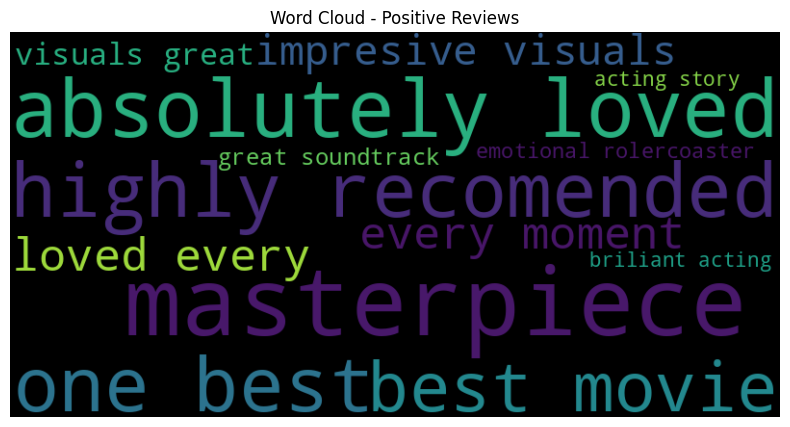

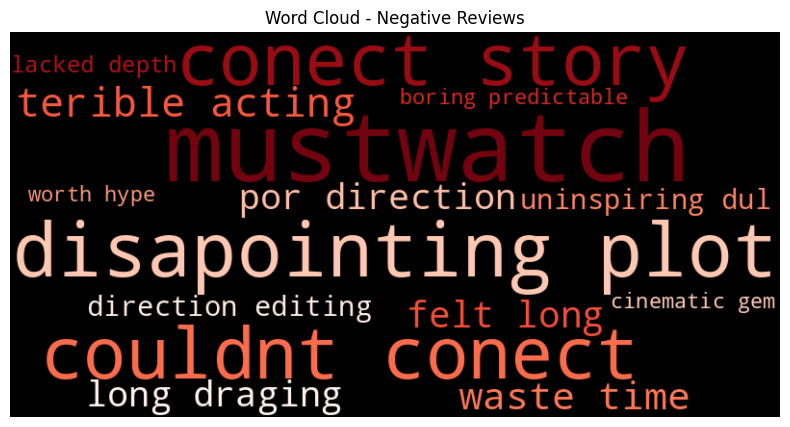

In [ ]:
#1.VADER LABELS
#Word Cloud for positive and Negative reviews
positive_text = " ".join(df[df['vader_to_num'] == 1]['cleaned_review'])
wc = WordCloud(width=800, height=400, background_color='black').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud - Positive Reviews")
plt.axis("off")
plt.show()


negative_text = " ".join(df[df['vader_to_num'] == 0]['cleaned_review'])
wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud - Negative Reviews")
plt.axis("off")
plt.show()


In [ ]:
#as the data is unbalanced we should balance before using to train the model
min_count = df['vader_to_num'].value_counts().min()
df_balanced = pd.concat([
    df[df['vader_to_num'] == 0].sample(min_count, random_state=42),
    df[df['vader_to_num'] == 1].sample(min_count, random_state=42)
])


In [ ]:

vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
x=vectorizer.fit_transform(df_balanced['cleaned_review'])
y = df_balanced['vader_to_num']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Classification Report:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        17

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Confusion Matrix:
 [[20  0]
 [ 0 17]]


In [ ]:
new_reviews = [
    "A must-watch film I've seen.",
    "Worst movie I've ever seen. Terrible acting and plot.",
    "It was okay, not bad but not great either.",
    "The cinematography was stunning but the story lacked depth.",
    "this movie has terrible acting.it has bad story line ",
    "What a boring movie",
    "Absolutely loved the storyline and visuals"
]
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(.)\1+',r'\1',text)
    text = re.sub(r'<.*?>','',text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

cleaned = [preprocess_text(review) for review in new_reviews]

X_new = vectorizer.transform(cleaned)

predictions = model.predict(X_new)

for review, pred in zip(new_reviews, predictions):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Review: A must-watch film I've seen.
Predicted Sentiment: Negative

Review: Worst movie I've ever seen. Terrible acting and plot.
Predicted Sentiment: Negative

Review: It was okay, not bad but not great either.
Predicted Sentiment: Positive

Review: The cinematography was stunning but the story lacked depth.
Predicted Sentiment: Negative

Review: this movie has terrible acting.it has bad story line 
Predicted Sentiment: Negative

Review: What a boring movie
Predicted Sentiment: Positive

Review: Absolutely loved the storyline and visuals
Predicted Sentiment: Positive



as you can see when we are using the vader labels to train the data and tested the model on new reviews it predicted 5/7 correctly. as you may think that the accuracyis 1.0 why can't it predict all correctly because the datset is small so it got accuracy as 1.0 when came to prediction there is some mislead.

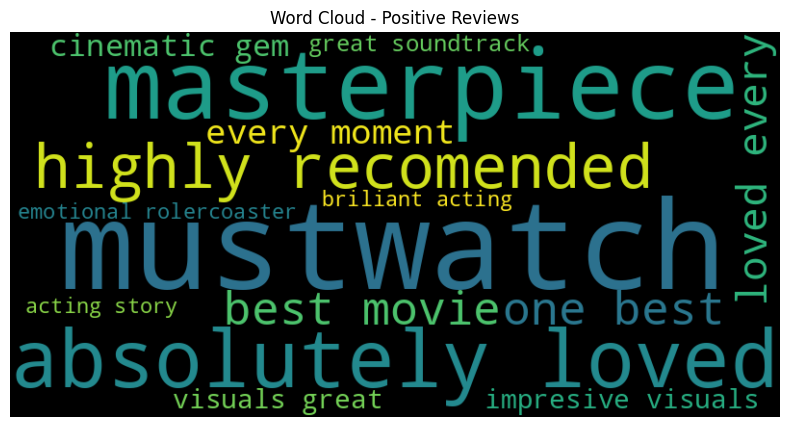

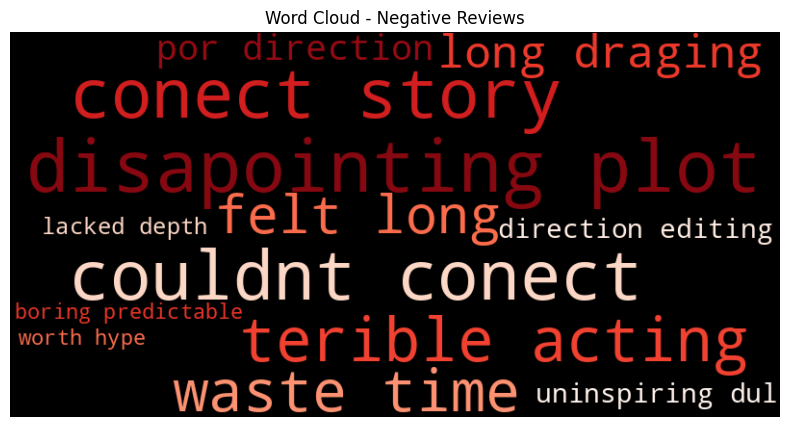

In [ ]:
#2.Human generated labels
#Word Cloud for positive and Negative reviews
positive_text = " ".join(df[df['sentiment_to_num'] == 1]['cleaned_review'])
wc = WordCloud(width=800, height=400, background_color='black').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud - Positive Reviews")
plt.axis("off")
plt.show()


negative_text = " ".join(df[df['sentiment_to_num'] == 0]['cleaned_review'])
wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud - Negative Reviews")
plt.axis("off")
plt.show()


In [ ]:
#as the data is unbalanced we should balance before using to train the model
min_count = df['sentiment_to_num'].value_counts().min()
df_balanced = pd.concat([
    df[df['sentiment_to_num'] == 0].sample(min_count, random_state=42),
    df[df['sentiment_to_num'] == 1].sample(min_count, random_state=42)
])

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
x=vectorizer.fit_transform(df_balanced['cleaned_review'])
y = df_balanced['sentiment_to_num']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:",accuracy_score(y_test,y_pred))
print("Classification Report:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        25

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

Confusion Matrix:
 [[27  0]
 [ 0 25]]


In [ ]:
new_reviews = [
    "This is best movies I've seen.",
    "Worst movie I've ever seen. Terrible acting and plot.",
    "It was okay, not bad but not great either.",
    "The cinematography was stunning but the story lacked depth.",
    "this movie has terrible acting.it has bad story line ",
    "What a boring movie",
    "Absolutely loved the storyline and visuals"
]
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(.)\1+',r'\1',text)
    text = re.sub(r'<.*?>','',text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

cleaned = [preprocess_text(review) for review in new_reviews]

X_new = vectorizer.transform(cleaned)

predictions = model.predict(X_new)

for review, pred in zip(new_reviews, predictions):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

Review: This is best movies I've seen.
Predicted Sentiment: Positive

Review: Worst movie I've ever seen. Terrible acting and plot.
Predicted Sentiment: Negative

Review: It was okay, not bad but not great either.
Predicted Sentiment: Positive

Review: The cinematography was stunning but the story lacked depth.
Predicted Sentiment: Negative

Review: this movie has terrible acting.it has bad story line 
Predicted Sentiment: Negative

Review: What a boring movie
Predicted Sentiment: Negative

Review: Absolutely loved the storyline and visuals
Predicted Sentiment: Positive



as you can see when we trained the model using the human generated labels the model predicted 7/7 on the new reviews correctly so there is a little difference in sentimental analysis when we are using the vader labels and human generated labels .even though the human generated labels used model predicted correctly but always humans cant generate labels on huge datset so if weuse the vader technique it will automatically generate the labels even for a huge datset also.